In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec

from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm


Using TensorFlow backend.


In [2]:
from astrohack import *
import astrohack

In [3]:
astrohack.dataFolder = 'data/mainData/'
astrohack.dataFolder = 'data/mainData_original/'

df = getAstrohackDataFrame()

plt.ion()
plt.show()

df.head()

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,index,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,...,F-clean.flux.sum,F-clean.flux.min,F-clean.flux.max,F-clean.flux.mean,F-clean.flux.std,F-clean.centerflux,F-cleanaroundCenter.flux,F-clean.imgsize,1/D2,1/D
0,174,1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,2.472975,...,335.738342,0.0,0.311663,0.006691,0.017449,0.295520,0.291456,224.0,0.000009,0.003066
1,216,1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.841365,...,395.414642,0.0,0.332071,0.007881,0.018507,0.262002,0.266867,224.0,0.000012,0.003406
2,237,1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.703785,...,647.506958,0.0,0.741703,0.012905,0.036231,0.718606,0.676279,224.0,0.000036,0.005983
3,276,1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.248502,...,1033.956177,0.0,0.408230,0.020607,0.032396,0.408230,0.365300,224.0,0.000013,0.003546
4,332,1237662474232398001,246.28905,29.94774,0.446684,0.0455,25.337321,194.999996,0.378155,0.419816,...,468.694305,0.0,0.332187,0.009341,0.024021,0.294655,0.301434,224.0,0.000026,0.005128


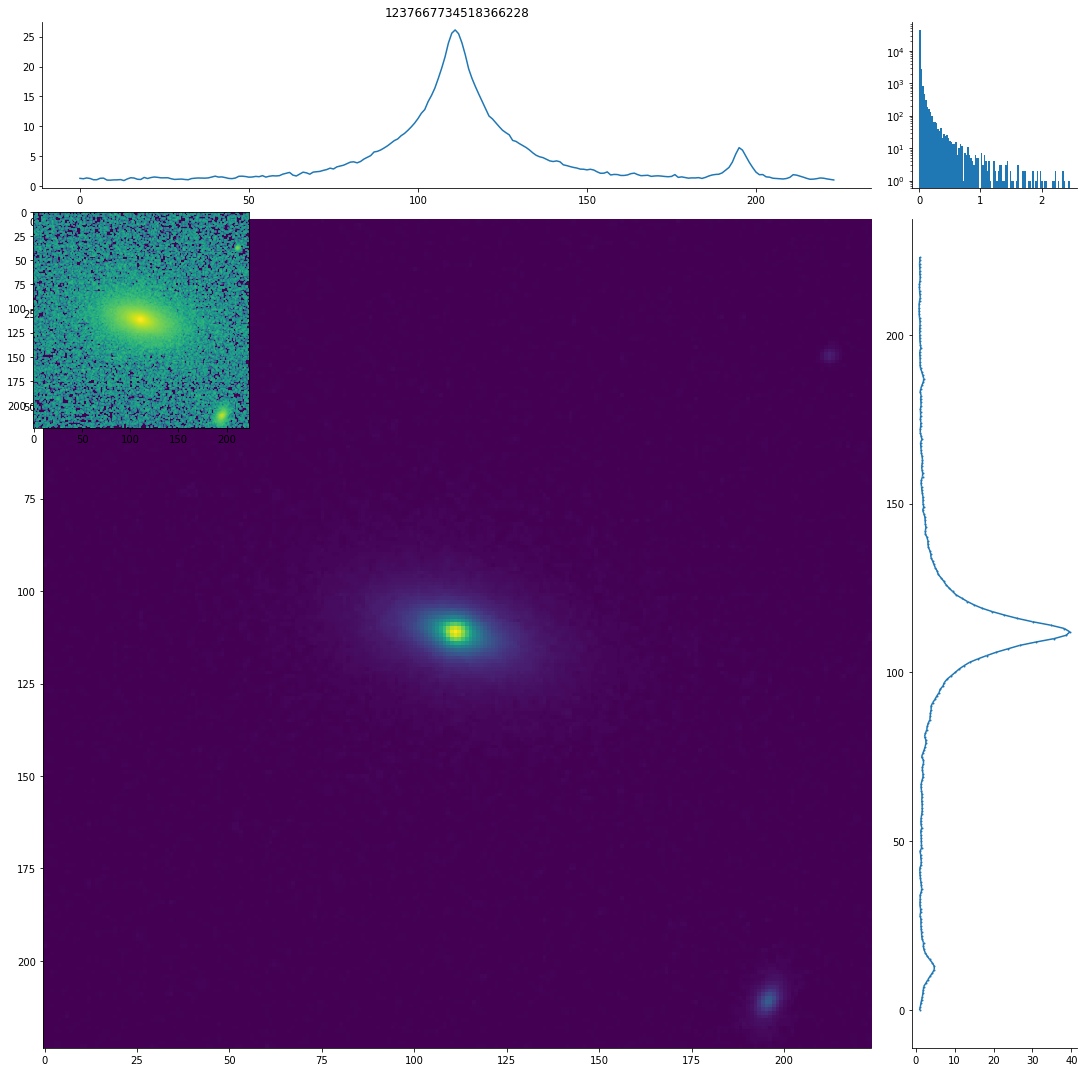

In [4]:
X = read_image('1237667211059986578')
X = cleanupImage(X)
X = img_preprocnoread(X, 1) 
X = img_preproc('1237667211059986578',79)
# plt.imshow(img_preproc('1237667211059986578', 16+32+64))
# plt.show()
# 1 for vlip (PP_VFLIP)
# 2 for hflip (PP_HFLIP)
# 4 for rotate90 (PP_ROTATE)
# 8 for scale[0,1] (PP_SCALE)
# 16 for log1p (PP_LOG1P)
# 32  for normalize ([-mean/std]) (PP_NORMALIZE)
# 64 for crop (PP_CROP)
# 128 hackaton cleanup (PP_HACKATON)

drawOneGalaxy(df.SDSS_ID.values[random.randint(0,len(df.SDSS_ID))],PP_HACKATON+PP_LOG1P+PP_ROTATE+PP_HFLIP)

# score = xi2(truth, pred, error)



### Read metadata file

In [5]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        
    def on_train_begin(self, logs={}):
        self.initVars()
        self.referenceLoss = xi2(self.referencePrediction, data[TEST+TRUTH], data[TEST+ERROR])

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(6,6))

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="val loss")
        ax.set_yscale("log", nonposy='clip')
        plt.legend()
        
plot_losses = PlotLosses()

In [6]:
curIDX = 22

In [7]:
plt.ion()
plt.show()

(6272,)

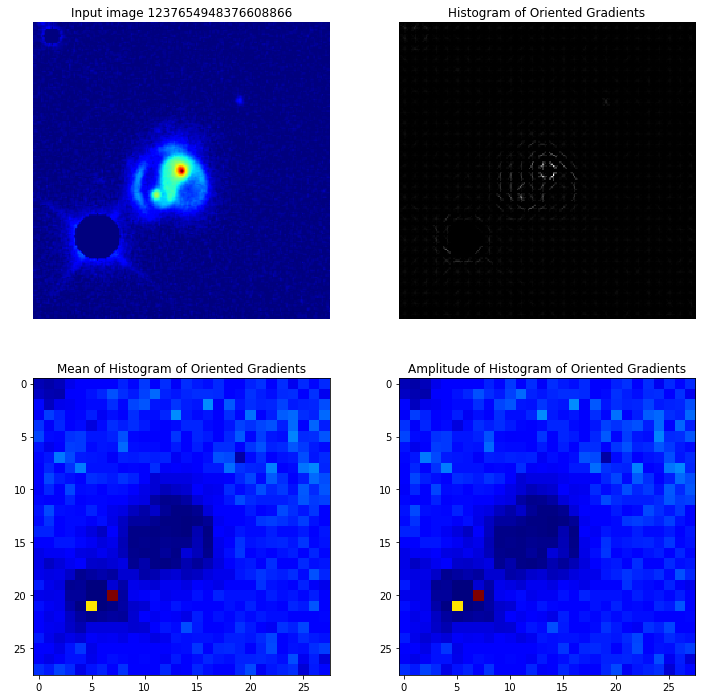

In [162]:
import skimage
from skimage.feature import hog
from skimage import data, color, exposure



curIDX = curIDX+1
x = read_image(df.SDSS_ID.values[curIDX])
x = img_preproclist(x, [PP_HACKATON, PP_LOG1P, 0])
# x[0:16,0:16] = np.zeros((16,16))

fd, hog_image = hog(x, orientations=8, pixels_per_cell=(8, 8),cells_per_block=(1, 1), visualise=True, block_norm='L2-Hys')

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12), sharex=True, sharey=True)


plt.figure(figsize=(12,12))
ax1 = plt.subplot(221)
ax1.axis('off')
ax1.imshow(np.log1p(x), cmap='jet')
ax1.set_title('Input image '+str(df.SDSS_ID.values[curIDX]))
ax1.set_adjustable('box-forced')

ax2 = plt.subplot(222)
# Rescale histogram for better display
hog_image_rescaled = hog_image # exposure.rescale_intensity(hog_image, in_range=(0, 0.02))


ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')


ax2 = plt.subplot(223)

ax2.set_title('Mean of Histogram of Oriented Gradients')
fdr = fd.reshape((28,28,8))

plt.imshow(abs(fdr).mean(axis=2), cmap='jet')

ax2 = plt.subplot(224)
ax2.set_title('Amplitude of Histogram of Oriented Gradients')

plt.imshow(abs(fdr).sum(axis=2), cmap='jet')

fd.shape

In [9]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    epochsPerDraw = 10
    referencePrediction = None
    
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.test_losses = [] # external validation
        self.fig = plt.figure()
        self.logs = []
        self.lr = []
        self.lasttrainplot = None
        self.lasttestplot = None
        
    def on_train_begin(self, logs={}):
        self.initVars()
#         self.referenceLoss = xi2(self.referencePrediction, data[TEST+TRUTH], data[TEST+ERROR])

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        self.logs.append(logs)
        self.x.append(self.i)
        currentLearningRate = K.get_value(model.optimizer.lr)
        self.lr.append(currentLearningRate)

        if ( self.i %self.epochsPerDraw != 0 ):
            return

        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.suptitle("{}/{} {}".format(self.i, numEpochs, curloss))
        
#         ax = plt.subplot(121)
#         if self.lasttestplot == None or self.i %self.epochsPerDraw == 0:
#             self.plotSelfTest(ax)
#         else:
#             ax = self.lasttestplot
    
        ax = plt.subplot(122)
        self.plotLosses(ax)
        

#         plt.savefig("pltsave/" + prefixThisRound + "%05d.png" % self.i)
        plt.show();
    
    def plotSelfTrain(self, ax):

        pred = model.predict(data[TRAIN+FEATURES])[:,0]
        r = xi2(pred,data[TRAIN+TRUTH], data[TRAIN+ERROR])
        plt.scatter(x=data[TRAIN+TRUTH], y=pred, c='k', alpha=.1, label="NN train {:.2f}".format(r))
        plt.xlabel('ML_g truth')
        plt.ylabel('prediction')
        plt.legend()
        self.lasttrainplot = ax
    
    def plotSelfTest(self, ax):
        
        # lgbm values
        plt.scatter(x=data[TEST+TRUTH], 
                    y=self.referencePrediction, 
                    c='b', alpha=.1, label="ref {:02f}".format(self.referenceLoss))
        
        # test values
        pred = model.predict(data[TEST+FEATURES])[:,0]
        r = xi2(pred,data[TEST+TRUTH], data[TEST+ERROR])
        plt.scatter(x=data[TEST+TRUTH], y=pred, c='g', alpha=.1, label="NN test {:.2f}".format(r))
        plt.xlabel('ML_g truth')
        plt.ylabel('prediction')
        plt.plot([0, 12], [0, 12], 'k-', lw=2, label="target")
        plt.legend()
        self.lasttestplot = ax

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="val loss")
        ax.set_yscale("log", nonposy='clip')
#         ax.axhline(self.referenceLoss,linestyle='--')
        plt.legend()
        ax2 = ax.twinx()
        ax2.set_yscale('log')
        plt.plot(self.x,self.lr, c='r', label='learning rate', alpha=0.8)
        
        plt.legend()

        
plot_losses = PlotLosses()

In [60]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.optimizers import *
from keras.layers import *
from keras.models import Model

input_img = Input(shape=(56, 56, 8))
# input_img = Input(shape=(28, 28, 8))
# input_img = Input(shape=(224, 224, 1))
extraFeatures = Input(shape=(27,))
x = input_img

x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = Dropout(0.6)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = Dropout(0.6)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = Dropout(0.6)(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)

x = Dense(1000)(x)
x = LeakyReLU()(x)
x = Dropout(0.6)(x)
x = BatchNormalization()(x)
x = Dense(300)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dense(100)(x)
x = concatenate([x,extraFeatures])
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Dense(1)(x)


model = Model([input_img, extraFeatures], x)
model.compile(optimizer='nadam', loss='mse')


In [42]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 28, 28, 8)     0                                            
____________________________________________________________________________________________________
conv2d_11 (Conv2D)               (None, 28, 28, 64)    4672        input_5[0][0]                    
____________________________________________________________________________________________________
leaky_re_lu_17 (LeakyReLU)       (None, 28, 28, 64)    0           conv2d_11[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D)  (None, 14, 14, 64)    0           leaky_re_lu_17[0][0]             
___________________________________________________________________________________________

In [30]:
N = df.shape[0]
M = int(N*0.9) # test = 900->1000
df = df.sample(frac=1) # shuffle

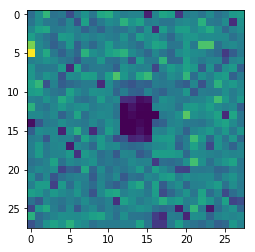

In [31]:
x = img_preproclist(df.SDSS_ID.values[1], [PP_RESCALE224])
plt.imshow(fd.reshape(28,28,8)[:,:,3])


In [62]:
def hogimage(Xg):
    fd = hog(Xg, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(1, 1), visualise=False, block_norm='L2-Hys')
    return fd.reshape(56,56,8)


In [33]:
extraFNames = [x for x in df.columns if x[0:2] == 'F-'] + ['D_Mpc', '1/D', '1/D2']
df[extraFNames].shape


(76908, 27)

In [63]:
x_test = np.stack([ hogimage(img_preproclist(x, [PP_RESCALE224])) for x in df.SDSS_ID.values[M:N] ])
# x_test = np.stack([ img_preproclist(x, [PP_LOG1P, PP_SCALE, PP_RESCALE224]) for x in df.SDSS_ID.values[M:N]])[:,:,:,newaxis]
x_test_extra = df[extraFNames].values[M:N]
print(x_test.shape)
y_test = df.ML_g.values[M:N]
err_test = df.ML_g_rel_err.values[M:N] * y_test

x_train = np.stack([ hogimage(img_preproclist(x, [PP_RESCALE224])) for x in df.SDSS_ID.values[:M] ])
# x_train = np.stack([ img_preproclist(x, [PP_LOG1P, PP_SCALE, PP_RESCALE224]) for x in df.SDSS_ID.values[:M]])[:,:,:,newaxis]
x_train_extra = df[extraFNames].values[:M]
print(x_train.shape)
y_train = df.ML_g.values[:M]
err_train = df.ML_g_rel_err.values[:M] * y_train

(7691, 56, 56, 8)
(69217, 56, 56, 8)


In [64]:
basicLossPlot = PlotLosses()


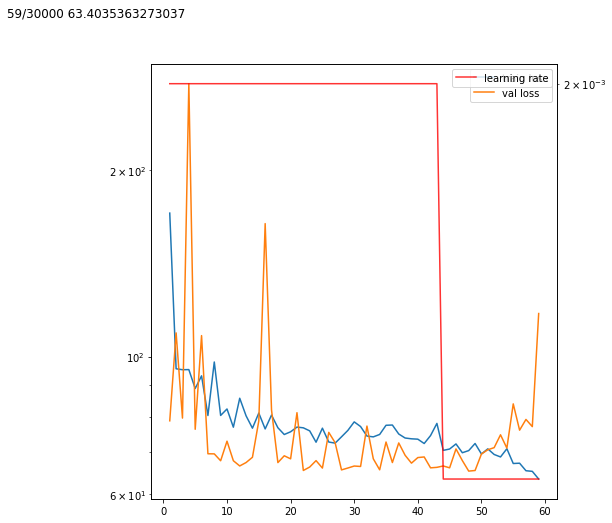

50s - loss: 63.4035 - val_loss: 117.3909
Epoch 60/30000


KeyboardInterrupt: 

In [65]:
reduceLRcallback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, verbose=0, mode='auto', epsilon=0.0001, cooldown=20, min_lr=1e-8)

numEpochs = 30000
basicLossPlot.epochsPerDraw = 1
# num = 5000
num = N

model.fit([x_train, x_train_extra], 
          y_train, 
          sample_weight=1/err_train**2,
          batch_size=30, 
          epochs=numEpochs, 
          validation_data = ([x_test, x_test_extra], y_test, 1/err_test**2),
          verbose = 2,
          callbacks=[basicLossPlot,reduceLRcallback])



In [ ]:
pred = model.predict([x_test, x_test_extra])[:,0]

xi2andPlot(pred, y_test, err_test)
# xi2(pred,y_test, err_test)


# sns.kdeplot(pred, y_test, alpha=1, cmap=cmap, shade=True, bw=0.2, cut=0)
# pred[:,0]